##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

**Data cleaning & stemming**

In [104]:
import re
from nltk.corpus import stopwords

def clean(texts, feature='all', remove_instance=False):
    if feature == 'username' or feature == 'all':
        if remove_instance:
            pattern = r'@[A-Za-z0-9]+'
        else:
            pattern = r'@'
        texts = texts.str.replace(pattern, '', regex=True)
        
    if feature == 'hashtag' or feature == 'all':
        if remove_instance:
            pattern = r'#[A-Za-z0-9]+'
        else:
            pattern = r'#'
        texts = texts.str.replace(pattern, '', regex=True)
        
    if feature == 'url' or feature == 'all':
        texts = texts.str.replace(r'https?:\/\/\S+', '', regex=True)
        
    if feature == 'alphanumeric' or feature == 'all':
        texts = texts.str.replace(r'[^a-zA-Z0-9 #]', '', regex=True)
    
    return texts

def remove_stopwords(texts):
    stop_words = set(stopwords.words('english'))
    tokenized_texts = texts.str.split(' ')
    tokenized_texts = tokenized_texts.apply(lambda sentence: [word for word in sentence if word not in stop_words])
    return tokenized_texts.str.join(' ')
    
def stem(texts, method):
    tokenized_texts = texts.str.split(' ')
    tokenized_texts = tokenized_texts.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
    return tokenized_texts.str.join(' ')

**Data analysis**

In [98]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)
df['text'] = clean(df['text'])


*Wordcloud*

In [99]:
def generate_wordcloud(df, sentiment):
    words = " ".join([tweet for tweet in df['text'][df['sentiment'] == sentiment]])
    wordcloud = WordCloud(random_state=42).generate(words)
    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud)
    plt.title(sentiment)
    plt.axis('off')
    plt.show()

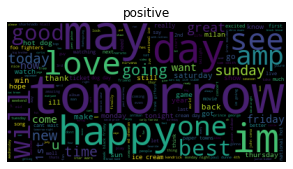

In [100]:
generate_wordcloud(df, 'positive')

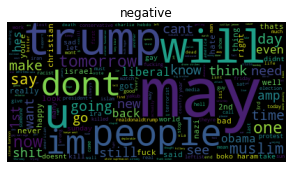

In [ ]:
generate_wordcloud(df, 'negative')

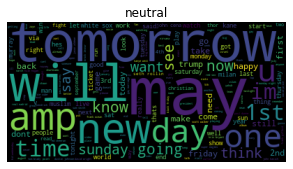

In [94]:
generate_wordcloud(df, 'neutral')

*Sentiment distribution*

<AxesSubplot:title={'center':'Sentiment distribution'}>

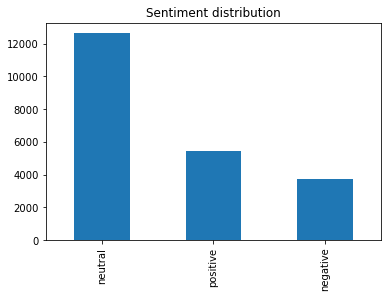

In [73]:
plt.title('Sentiment distribution')
df['sentiment'].value_counts().plot(kind='bar')

**Split training and testing data**

In [4]:
from sklearn.model_selection import train_test_split

def data_split(df, test_size):
    X = df['text']
    y = df['sentiment']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

**Feature vectorization**

In [5]:
def vectorise(train, test, method):
    vectorizer = method
    
    vectorised_train = vectorizer.fit_transform(train)
    vectorised_test = vectorizer.transform(test)
    
    return vectorised_train, vectorised_test

**Evaluation**

In [6]:
def evaluate(actual_classes, pred_classes):
    accuracy = accuracy_score(actual_classes, pred_classes)
    confusion_display = pd.DataFrame(confusion_matrix(actual_classes, pred_classes, labels=['positive', 'negative', 'neutral']),
                                    index=['actual: positive', 'actual: negative', 'actual: neutral'],
                                    columns=['pred: positive', 'pred: negative', 'pred: neutral'])
        
    print('Accuracy:', accuracy)
    print('Confusion matrix:\n', confusion_display)
    print('\n')

**Classification testing main**

In [97]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("Train.csv", sep=',', skipinitialspace=True)

df['text'] = clean(df['text'])
df['text'] = remove_stopwords(df['text'])

X_train, X_test, y_train, y_test = data_split(df, 0.1)

X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer())

models = [DummyClassifier(strategy='most_frequent'),
          MultinomialNB(),
          svm.LinearSVC(),
          LogisticRegression(max_iter=200)]

titles = ['Zero-R',
          'Multinomial NB',
          'Linear SVC',
          'Logistic Regression']  

for title, model in zip(titles, models): 
    model.fit(X_train_tfidf, y_train)
    pred = model.predict(X_test_tfidf)
    print(title)
    evaluate(y_test, pred)

Zero-R
Accuracy: 0.5905547913801009
Confusion matrix:
                   pred: positive  pred: negative  pred: neutral
actual: positive               0               0            513
actual: negative               0               0            380
actual: neutral                0               0           1288


Multinomial NB
Accuracy: 0.6107290233837689
Confusion matrix:
                   pred: positive  pred: negative  pred: neutral
actual: positive              55               0            458
actual: negative               1               2            377
actual: neutral               13               0           1275


Linear SVC
Accuracy: 0.6607060981201284
Confusion matrix:
                   pred: positive  pred: negative  pred: neutral
actual: positive             287              12            214
actual: negative              27             146            207
actual: neutral              169             111           1008


Logistic Regression
Accuracy: 0.671251719394773
C

**Test set final classification**

In [349]:
from sklearn.linear_model import LogisticRegression

train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

X_train = train_data['text']
y_train = train_data['sentiment']

X_test = test_data['text']

# clean data
X_train = clean(X_train)
X_test = clean(X_test)

X_train = stem(X_train, lemmatizer)
X_test = stem(X_test, lemmatizer)

X_train_tfidf, X_test_tfidf = vectorise(X_train, X_test, TfidfVectorizer(stop_words='english'))

# fit and predict
logistic_regression = LogisticRegression(max_iter=200)
logistic_regression.fit(X_train_tfidf, y_train)
test_predicted = logistic_regression.predict(X_test_tfidf)

In [350]:
# output to csv file
output_pd = pd.DataFrame(list(zip(test_data['id'], test_predicted)), columns=['id', 'sentiment'])
output_pd.to_csv('test_predictions.csv', index=False)